In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

### Preprocessing origin data

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    y = np.round(y)
    y = y.astype(int)
    
    ## Let's shift each signal so that reference time matches for each signal
    mean_ref_time = int(y.mean())
    X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])

    return X, y

def get_freq_data(X, freq=1, start_point=384):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [3]:
X_origin, y_origin = get_data()

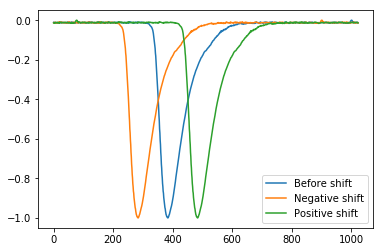

In [4]:
plt.plot(X_origin[0])
plt.plot(signal_cyclic_shift(X_origin[0], -100))
plt.plot(signal_cyclic_shift(X_origin[0], 100))

plt.legend(['Before shift', "Negative shift", "Positive shift"])
plt.show()

##### Let's shift each signal so that reference time matches for each signal

Mean reference time = 166.74566768603466


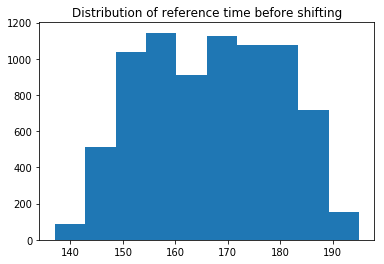

In [5]:
plt.title("Distribution of reference time before shifting")
plt.hist(y_origin)
mean_ref_time = int(y_origin.mean())
print("Mean reference time =", y_origin.mean())

### Generating multi signals

#### We will generate the signal the following way:
#### We have already shifted all the signals, so that they have the same reference time,
#### new signal will be calculated as first_signal*alpha + second_signal,
#### then normalization will be applied to new_signal, so that the impulse is in range from 0 to -1,
#### after that the first signal, the second signal and the new signal will be shifted, so that the location of minimum
#### of impulse matches for all of three signals
#### -----------------------------------------------------------------------------------------------
#### Let's figure out the location of minimum we will shift our signals to:

Mean argmin = 384.20412844036696


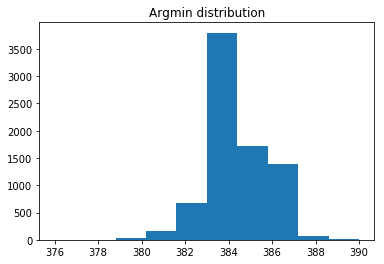

In [6]:
plt.title("Argmin distribution")
plt.hist(np.argmin(X_origin, axis=1))
mean_argmin =  int(np.argmin(X_origin, axis=1).mean())
print("Mean argmin =", np.argmin(X_origin, axis=1).mean())

In [42]:
import random

def generate_multi_signal(X_origin, tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(X_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    
    ### Randomly choose what signal to shift
    if random.choice([True, False]):
        first_impulse = signal_cyclic_shift(first_impulse, tau)
    else:
        second_impulse = signal_cyclic_shift(second_impulse, tau)
    
    
    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

    if to_plot:
        plt.plot(first_impulse_shifted)
        plt.plot(second_impulse_shifted)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
    return {'first': first_impulse_shifted,\
            'second': second_impulse_shifted,\
            'multi': multi_impulse_shifted}

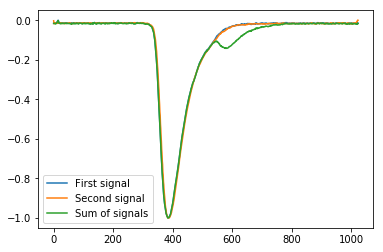

{'first': array([-0.01471836, -0.01483491, -0.01374059, ..., -0.01442049,
        -0.01711422, -0.01495147]),
 'second': array([-0.00255797, -0.01734665, -0.01734665, ..., -0.00130469,
        -0.00192169,  0.        ]),
 'multi': array([-0.01636225, -0.01647862, -0.0154329 , ..., -0.01603792,
        -0.01869007, -0.01657702])}

In [43]:
generate_multi_signal(X_origin, 200, 0.1, to_plot=True)

##### Fixate tau and alpha parameters

In [9]:
tau = 0
alpha = 0.0001

### Preparing data

In [10]:
from sklearn.utils import shuffle

def prepare_data(X_origin, tau, alpha, data_size=1000, to_print=False):
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X_positive = np.array([generate_multi_signal(X_origin, tau, alpha)['first'] for i in range(pos_size)])
    y_positive = np.ones(pos_size)
    
    X_negative = np.array([generate_multi_signal(X_origin, tau, alpha)['multi'] for i in range(neg_size)])
    y_negative = np.zeros(neg_size)
    
    X = np.concatenate([X_positive, X_negative])
    y = np.concatenate([y_positive, y_negative])
   
    if to_print:
        print("X positive shape:", X_positive.shape)
        print("y positive shape:", y_positive.shape)
        print("X negative shape:", X_negative.shape)
        print("y negative shape:", y_negative.shape)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [11]:
X, y = prepare_data(X_origin, tau, alpha, to_print=True)

X positive shape: (500, 1024)
y positive shape: (500,)
X negative shape: (500, 1024)
y negative shape: (500,)
X shape: (1000, 1024)
y shape: (1000,)


### Splitting our data for train and test

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

print("X_train.shape:", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train.shape: (700, 1024)
y_train.shape (700,)
X_test shape: (300, 1024)
y_test shape: (300,)


### Ensemble

In [13]:
from scipy.stats import rankdata
from itertools import cycle
from sklearn.base import BaseEstimator, ClassifierMixin

class ShuffleVoter(BaseEstimator, ClassifierMixin):  
    """
       scikit-learn based voting aggregation ensembling.
       Using bootstrapping creates a set of models, differing only by which data sample they are fed
       """

    def __init__(self, models):
        """
        model - base model ( or a pipeline ) ( unfitted )
        """
        self.models = models
        
    def ensemble_predictions(self, predictions, weights, type_="harmonic"):
        """
        Combines probabilistic class estimates using a variety of strategies.
        Linear, harmonic, geometric and rank averaging are supported at this moment. 
        Insipred by well known Abhishek's kernel on Kaggle 
        model - base model ( or a pipeline ) ( unfitted )
        """
        assert np.isclose(np.sum(weights), 1.0)
        if type_ == "linear":
            res = np.average(predictions, weights=weights, axis=0)
        elif type_ == "harmonic":
            res = np.average([1 / p for p in predictions], weights=weights, axis=0)
            return 1 / res
        elif type_ == "geometric":
            numerator = np.average(
                [np.log(p) for p in predictions], weights=weights, axis=0
            )
            res = np.exp(numerator / sum(weights))
            return res
        elif type_ == "rank":
            res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
            return res / (len(res) + 1)
        return res


    def fit( self, X, y, n_boots = 14, test_size = 100 ):
        """
        n_boots - number of bootstrapping iterations ( and respective models built)
        """
        self.clfs  = []
        for i, model in zip(range(n_boots), cycle(self.models)):
            X_tr, X_te, y_tr, y_te = train_test_split( X, y, test_size=test_size, random_state=3521 + i*11)

            pa_clf = model
            pa_clf.fit(X_tr, y_tr)

            self.clfs.append(pa_clf)

    def predict( self, X, ensemble_type = 'rank'):
        # TODO: nonuniform weights
        
        n_boots = len( self.clfs)
        preds = [ clf.predict(X) for clf in self.clfs ]
#         return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)
        return np.round(self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type))

    
    def predict_proba( self, X, ensemble_type = 'rank' ):
        n_boots = len( self.clfs)
        preds = [ clf.predict_proba(X) for clf in self.clfs ]
        return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)


### Defining pipelines

In [14]:
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [15]:
def get_pipelines(hyperparams = {'svc_c': 0.1, 'mlp_max_iter': 1000, 'kn_n': 5, 'pa_c': 0.0001}):
    SVC_pipeline = Pipeline([
                    ('clf', LinearSVC(C=hyperparams['svc_c'])),
                ])


    MLP_pipeline = Pipeline([
                    ('clf', MLPClassifier(max_iter=hyperparams['mlp_max_iter'])),
                ])

    KN_pipeline = Pipeline([
                    ('clf', KNeighborsClassifier(n_neighbors=hyperparams['kn_n'])),
                ])
    
    PA_pipeline = Pipeline([
                ('clf', PassiveAggressiveClassifier(C = hyperparams['pa_c'], max_iter=5000, tol=1e-3)),
            ])

    pipelines = {'svc': SVC_pipeline, 'kn': KN_pipeline, 'pa': PA_pipeline,  'mlp': MLP_pipeline}
    
    return pipelines

In [16]:
pipelines = get_pipelines()

### Pipelines scores:

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [18]:
for model_name, model in pipelines.items():
    print("Model name:", model_name)
    
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    scores = cross_validate(model, X, y, scoring=scoring, cv=10)
    for score in scoring.keys():
        print(score, "%0.5f (+/- %0.5f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))
    print('------------------------------')

Model name: svc
accuracy 0.47500 (+/- 0.08112)
precision 0.47342 (+/- 0.08357)
recall 0.48400 (+/- 0.15778)
f1_score 0.47736 (+/- 0.11529)
------------------------------
Model name: kn
accuracy 0.46400 (+/- 0.08863)
precision 0.46533 (+/- 0.09035)
recall 0.46400 (+/- 0.12106)
f1_score 0.46290 (+/- 0.09337)
------------------------------
Model name: pa
accuracy 0.49700 (+/- 0.01281)
precision 0.09949 (+/- 0.39799)
recall 0.10000 (+/- 0.58679)
f1_score 0.06962 (+/- 0.39274)
------------------------------
Model name: mlp
accuracy 0.49900 (+/- 0.00600)
precision 0.29949 (+/- 0.48908)
recall 0.50000 (+/- 0.99213)
f1_score 0.33628 (+/- 0.65756)
------------------------------


### Ensemble score

In [19]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
       'precision' : make_scorer(precision_score),
       'recall' : make_scorer(recall_score), 
       'f1_score' : make_scorer(f1_score)}

my_shuffle_voter = ShuffleVoter(list(pipelines.values()))
scores = cross_validate(my_shuffle_voter, X, y, scoring=scoring, cv=5)
for score in scoring.keys():
    print(score, "%0.9f (+/- %0.9f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))

accuracy 0.462000000 (+/- 0.044542115)
precision 0.447112789 (+/- 0.066456350)
recall 0.338000000 (+/- 0.289661872)
f1_score 0.371844477 (+/- 0.166874211)


### Let's plot accuracy scores for different sampling frequency values

In [20]:
alpha_values = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_values = range(-100, 110, 10)
freq_values = [1, 25, 50, 60, 75, 85, 100]
# alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [21]:
def calculate_scores(X_origin, alpha_values, tau_values, data_size=100, freq=1):
    scores_dict = {}
    
    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X, y = prepare_data(X_origin, tau, alpha, data_size=data_size)
            X = get_freq_data(X, freq=freq)

            pipelines = get_pipelines()

            scoring = {'accuracy' : make_scorer(accuracy_score)}
            scores = cross_validate(pipelines['kn'], X, y, scoring=scoring, cv=5)

            scores_dict[tau][alpha] = scores["test_accuracy"].mean()
    return scores_dict

In [22]:
def dict_to_arrays(scores_dict):
    x, y, z = [], [], []
    for tau, alpha_dict in scores_dict.items():
        for alpha, score in alpha_dict.items():
            x.append(tau)
            y.append(alpha)
            z.append(score)
            
    return [x, y, z]

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
# matplotlib.use('Qt4Agg')

def plot_score_3d(scores_dict):
    x, y, z = dict_to_arrays(scores_dict)
    alpha_values = list(scores_dict[list(scores_dict.keys())[0]].keys())
    
    fig1 = matplotlib.pyplot.figure(figsize=(7, 5))
    ax1 = Axes3D(fig1)

    ax1.set_yticks(np.log10(alpha_values[::10]))
    ax1.set_yticklabels(alpha_values[::10])

    ax1.set_xlabel(r"${\tau}$", fontsize=15)
    ax1.set_ylabel(r"${\alpha}$", fontsize=15)
    ax1.set_zlabel('Accuracy', fontsize=15)

#     ax1.view_init(30, 150)
    ax1.plot(10*x, np.log10(10*y), 10*z, 'ro', color='b', linewidth=3)

    for angle in range(0, 180):
        ax1.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

    plt.show()

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_color_map(scores_dict, alpha_values, tau_values, alpha_freq=10, tau_freq=4, freq=1):
    _, _, z = dict_to_arrays(scores_dict)
    z = np.array(z)
    Z = z.reshape((len(tau_values), len(alpha_values)))

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.title("Accuracy, freq = " + str(freq))
    plt.xlabel("Two signals ratio", fontsize=12)
    plt.ylabel("Delta t [ns]", fontsize=12)
    plt.xticks([alpha_freq*i for i in range(len(alpha_values[::alpha_freq]))], alpha_values[::alpha_freq])
    plt.yticks([tau_freq*i for i in range(len(tau_values[::tau_freq]))], [0.2*el for el in tau_values[::tau_freq]])

    im = ax.imshow(Z, interpolation='bilinear', cmap='spring', aspect='auto')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    plt.colorbar(im, cax=cax)
    plt.show()

In [25]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

100%|██████████| 21/21 [1:04:59<00:00, 185.68s/it]


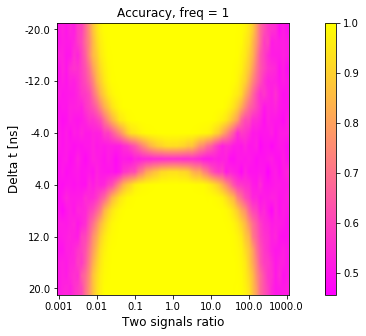

100%|██████████| 21/21 [11:13<00:00, 32.06s/it]


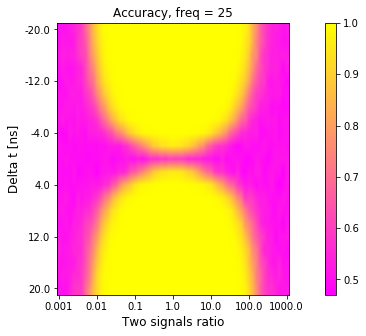

100%|██████████| 21/21 [10:37<00:00, 30.37s/it]


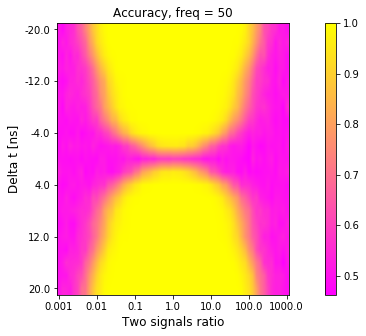

100%|██████████| 21/21 [10:35<00:00, 30.27s/it]


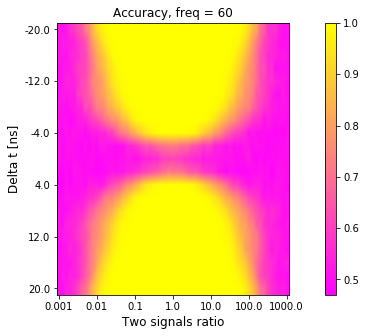

100%|██████████| 21/21 [10:28<00:00, 29.92s/it]


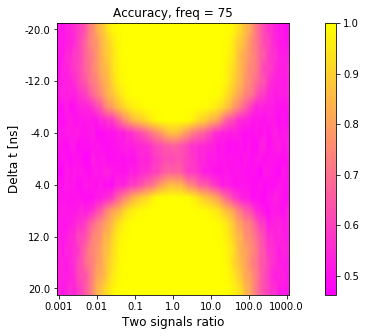

100%|██████████| 21/21 [11:28<00:00, 32.78s/it]


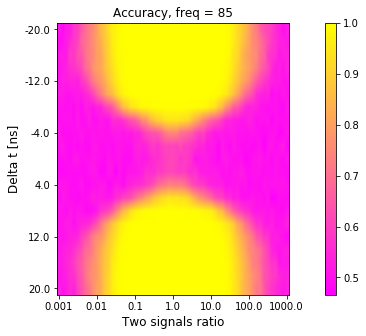

100%|██████████| 21/21 [12:25<00:00, 35.49s/it]


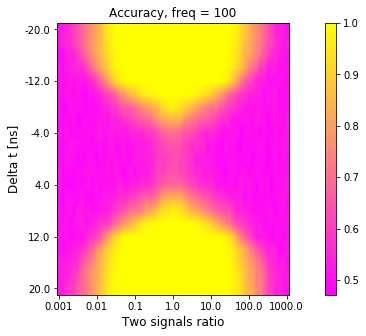

In [26]:
for freq in freq_values:
    X_origin, y_origin = get_data()
    scores_dict = calculate_scores(X_origin, alpha_values, tau_values, data_size=2000, freq=freq)
    plot_color_map(scores_dict, alpha_values, tau_values, freq=freq)
    save_obj(scores_dict, 'scores_freq=' + str(freq))
#     plot_score_3d(scores_dict)

### Let's take a look at mistakes distribution

In [148]:
tau = -100
data_size = 2000
freq = 1

In [149]:
def plot_mistakes_distr(y_test, y_pred, i):
    plt.subplot(331 + i)
    plt.title("tau = %i, alpha = %0.4f, acc = %0.4f" %(tau, alpha, scores_dict[tau][alpha]), fontsize=10)
    
    fp_num = len([i for i in range(len(y_test)) if y_test[i] == 0 and y_pred[i] == 1])
    fn_num = len([i for i in range(len(y_test)) if y_test[i] == 1 and y_pred[i] == 0])
    
    x = np.arange(2)
    plt.bar(x, height=[fp_num, fn_num])
    plt.xticks(x, ['False positive','False negative'])

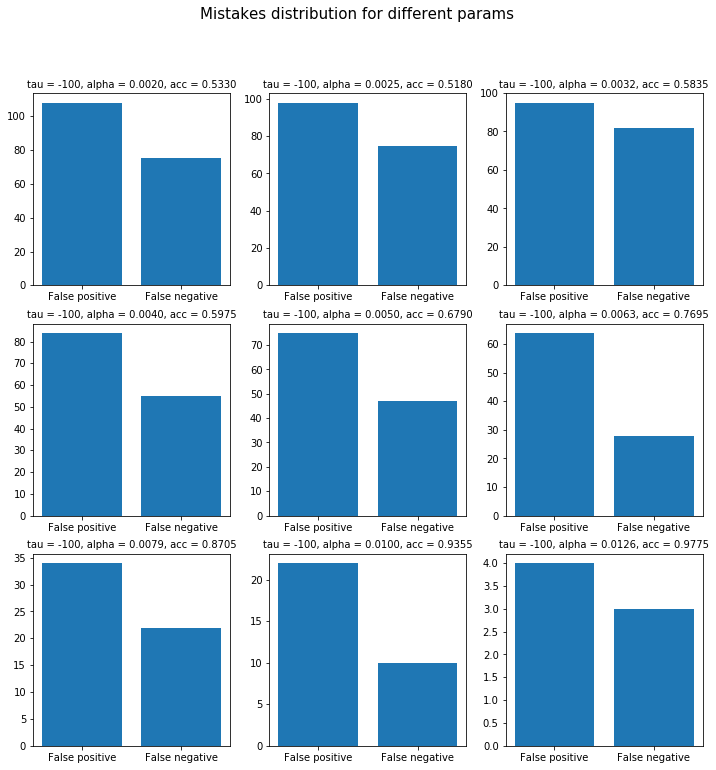

In [150]:
fig=plt.figure(figsize=(12, 12))
fig.suptitle('Mistakes distribution for different params', fontsize = 15)

for i, alpha in enumerate(alpha_values[3:12], 0):
    X_origin, y_origin = get_data()
    X, y = prepare_data(X_origin, tau, alpha, data_size=2000)
    X = get_freq_data(X, freq=freq)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

    pipelines = get_pipelines()
    model = pipelines['kn']

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
  
    plot_mistakes_distr(y_test, y_pred, i)
plt.show()

##### As we can see our algorithm more often decides that a multi signal is a single signal